now we will download the nltk library in purpose of use this library.

In [ ]:
nltk.download()

now we will install the tweepy library in purpose of use this library, in order to get data from tweeter API.

In [ ]:
!pip install tweepy

after download nltk we need to install it.

In [ ]:
!pip install nltk

now we will install the plotly library in purpose of use this library, in order to print diagrams in the future.

In [ ]:
!pip install plotly

# PART 1

We will connect to tweeter API using tweepy, we do this by using keys and tokens that we get in the time we opened tweeter application

In [1]:
import tweepy
%run keys.ipynb


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


get 50 most recent tweets of Donald Trump, Hillary Clinton, Barack Obama, Jerry Seinfeld, Gal Gadot.
WE will print for each one the number of tweets we got from him.

In [2]:
alltweets = []	
curr_length = 0

alltweets.extend(api.user_timeline(screen_name = "realDonaldTrump",count=50, tweet_mode = 'extended'))
print('Donald Trump has {0} tweets'.format(len(alltweets) - curr_length))
curr_length = len(alltweets)

alltweets.extend(api.user_timeline(screen_name = "HillaryClinton",count=50, tweet_mode = 'extended'))
print('Hillary Clinton has {0} tweets'.format(len(alltweets) - curr_length))
curr_length = len(alltweets)

alltweets.extend(api.user_timeline(screen_name = "BarackObama",count=50, tweet_mode = 'extended'))
print('Barack Obama has {0} tweets'.format(len(alltweets) - curr_length))
curr_length = len(alltweets)

alltweets.extend(api.user_timeline(screen_name = "JerrySeinfeld",count=50, tweet_mode = 'extended'))
print('Jerry Seinfeld has {0} tweets'.format(len(alltweets) - curr_length))
curr_length = len(alltweets)

alltweets.extend(api.user_timeline(screen_name = "GalGadot",count=50, tweet_mode = 'extended'))
print('Gal Gadot has {0} tweets'.format(len(alltweets) - curr_length))
curr_length = len(alltweets)

Donald Trump has 50 tweets
Hillary Clinton has 50 tweets
Barack Obama has 50 tweets
Jerry Seinfeld has 50 tweets
Gal Gadot has 50 tweets


Removes all hashtags, @, http words and # in order for the NLP to work better.
We also substitute each non letter char by " " .

In [3]:
import re

def clean_text(text):
    text_updated = " ".join(filter(lambda x: '#' not in x and '@' not in x and 'http' not in x, text.split()))
    return re.sub("[^a-zA-Z']",   # The pattern to search for: in this case- all characters but english letters
                      " ",                   # The pattern to replace it with
                      text_updated)

We will create a function for stemming a sentence in order to make the words in their original meaning.
It will improve our accuracy. We do this by using nltk library we downloaded before.

In [4]:
import nltk

porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

def stem_sentence(sentence):
    return " ".join([lancaster.stem(w) for w in sentence.split(" ")])


From the tweet object we will save only the text and the tweet's writer, after stemming and cleaning the text.

In [5]:
import pandas as pd
import numpy as np

TEXT_IDX = 1
NAME_IDX = 0

alltweets_name_and_text = [[tweet.user.name, clean_text(tweet.full_text)] for tweet in alltweets]

alltweets_text = [stem_sentence(tweet[TEXT_IDX]) for tweet in alltweets_name_and_text]
alltweets_name = [tweet[NAME_IDX] for tweet in alltweets_name_and_text]
alltweets_names_as_df = pd.DataFrame({'Name' : np.array(alltweets_name)})

print(alltweets_text)

['my admin has ident three maj pri for cre a saf  modern and law immigr system  ful sec the bord  end chain migr  and cancel the vis lottery  congress must sec the immigr system and protect am ', 'my thought and pray ar with the two pol off  their famy  and everybody at the', 'republ want to fix dac far mor than the democr do  the dem had al three branch of govern back in            and they decid not to do anyth about dac  they on want to us it as a campaign issu  vot republ ', '    ag  not just the fbi  amp  doj  now the stat depart to dig up dirt on him in the day lead up to the elect  comey had convers with donald trump  which i don t believ wer acc   he leak inform  corrupt    tom fitton of jud watch on', ' my view is that not on has trump been vind in the last sev week about the mishandl of the dossy and the lie about the clinton dnc dossy  it show that he s been victim  he s been victim by the obam admin who wer us al sort of       ', 'peopl liv ar being shat and destroy by a me

# PART 2

now we will use COuntVectorizor in order to create the bag of words, we will set the stop_words parameter to the stopword
in corpus in order to remove all of them for better classification, We also set the max_features to 1000 because we wanted the bag to be in medium large, that we will get good result, this size is according to the vocabulary size and tokenizing we will declare later.

In [6]:
from nltk.corpus import stopwords # Import the stop word list

print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

def create_bag_of_words(all_tweets):

    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = stopwords.words("english") ,   \
                                 max_features = 1000) 

    # fit_transform() Convert a collection of text documents (reviews in our example) to a matrix of token counts.
    # This implementation produces a sparse representation.
    # The input to fit_transform should be a list of strings.
    train_data_features = vectorizer.fit_transform(all_tweets)
    ###train_data_features = vectorizer.fit_transform(train['review'])
    
    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    return train_data_features.toarray()
    
train_data_features = create_bag_of_words(alltweets_text)

Creating the bag of words...



Now we will divide the input into train and test, in order to run the models on the train to fit them and on the test to find the model accuracy.

In [7]:
#split to train & test
msk = np.random.rand(len(train_data_features)) < 0.8

train_x = train_data_features[msk]
test_x = train_data_features[~msk]
train_y = alltweets_names_as_df.loc[msk, 'Name']
test_y = alltweets_names_as_df.loc[~msk, 'Name']

# Random Forest

Now we will use the random forest algorithm, which uses many tree-based classifiers to make predictions.
We have the bag of words result for each sentence and we also have who wrote it for each one. 
Below we set the number of trees to 100 because we saw it has better performance.

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
forest = forest.fit( train_x, train_y )

# Evaluate accuracy best on the test set
random_forest = forest.score(test_x,test_y)

random_forest

0.5370370370370371

# KNN

Now we will use the KNN algorithm,which make the disicion according to the majority of the neighbors of each new tweet.
The tuning parameters we did in this algorhitm is n_neighbors we set to be 13 and weights to be uniform.
We did this because we wanted the weight of each neighbor to be the same because we didnt want the distance from the neighbor to become factor. We chose n_neighbors to be 13 because we wanted to have enough neighbors so the prediction will be more accurate but not to many because it harms the accuracy when we take to many points.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize a knn classifier with n_neighbors = 13, weights = 'uniform'
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'uniform')

# Fit the knn to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
knn = knn.fit( train_x, train_y )

# Evaluate accuracy best on the test set
k_near_neighbur = knn.score(test_x,test_y)

k_near_neighbur

0.14814814814814814

# SVC

We used the SVM algorithm for predict the tweets owner.this is supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.This algorithm makes the disicion according to the location of the new tweet related to the hyperplane of the classifier. we use gamma to be 0.01 and c to be 100 and degree to be 3.  

In [10]:
from sklearn import svm

# Initialize a svc classifier with gamma = 0.001, C = 100, degree = 3
svc = svm.SVC(gamma = 0.001, C = 100, degree = 3)

# Fit the svc to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
svc = svc.fit( train_x, train_y )

# Evaluate accuracy best on the test set
support_vector = svc.score(test_x,test_y)

support_vector

0.5370370370370371

# Logistic Regression

We used the logistic regression algorithm for predict the tweets owner.this is a regression model where the dependent variable (DV) is categorical. the logistic regression as no need for variables in the initialization process. this model performs well on data that as factorize pridection variable with not a lot of options. 

In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize a logistic regression classifier.
regresion = LogisticRegression()

# Fit the regression to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
regresion = regresion.fit( train_x, train_y )

# Evaluate accuracy best on the test set
regression_logistic = regresion.score(test_x,test_y)

regression_logistic

0.6296296296296297

# Naive Bayes

naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features.Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.the Naive Bayes as no need for variables in the initialization process.


In [12]:
from sklearn.naive_bayes import GaussianNB

# Initialize a Naive Bayes classifier.
nb = GaussianNB()

# Fit the Naive Bayes to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
nb = nb.fit( train_x, train_y )

# Evaluate accuracy best on the test set
naive_bayes = nb.score(test_x,test_y)

naive_bayes

0.6481481481481481

now we will create a diagram that shows whice algorithm as the better result, and the result of each one from the 5 algorithm.

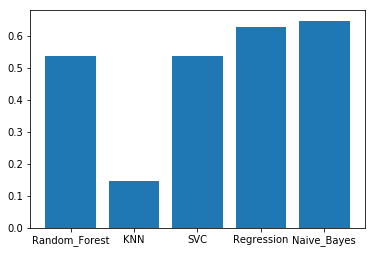

In [13]:
import matplotlib.pyplot as plt
import plotly.plotly as py

dictionary = plt.figure()

D = {u'Random_Forest':random_forest, u'KNN': k_near_neighbur, u'SVC':support_vector , u'Regression':regression_logistic, u'Naive_Bayes':naive_bayes}

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())

plt.show()

Here we could see that for the last 50 tweets of each person, the Naive_Bayes score is the best score

# part 3

# Deep Learning

install the keras library in order to create tweets for each of our 5 famous.

In [ ]:
!pip install keras==1.2

TensorFlow is also supported (as an alternative to Theano), but we stick with Theano to keep it simple. The main difference is that we will need to reshape the data slightly differently before feeding it to our network.

In [14]:
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.
C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



We will take all trumps tweets and make them a single sequence for each of our famous, every tweet in the sequences we will separate by the delimiter NEWTWEET, in order to know when to stop the creation of every tweet in the future.

In [15]:
TWEET_DELIMITER = ' NEWTWEET '

def get_tweets_texts_joined(tweets):
    tweets_text = [tweet.full_text for tweet in tweets]
    return TWEET_DELIMITER.join(tweets_text)
    
trump_tweets = api.user_timeline(screen_name = "realDonaldTrump",count=500, tweet_mode = 'extended')
trump_tweets = get_tweets_texts_joined(trump_tweets)

hilary_tweets = api.user_timeline(screen_name = "HillaryClinton",count=500, tweet_mode = 'extended')
hilary_tweets = get_tweets_texts_joined(hilary_tweets)

obama_tweets = api.user_timeline(screen_name = "BarackObama",count=500, tweet_mode = 'extended')
obama_tweets = get_tweets_texts_joined(obama_tweets)

seinfeld_tweets = api.user_timeline(screen_name = "JerrySeinfeld",count=500, tweet_mode = 'extended')
seinfeld_tweets = get_tweets_texts_joined(seinfeld_tweets)

gadot_tweets = api.user_timeline(screen_name = "GalGadot",count=500, tweet_mode = 'extended')
gadot_tweets = get_tweets_texts_joined(gadot_tweets)

Now we want to remove all hastag and tags (@, #) , and all the http words from the tweets.and get for each famous new sequence of tweets after cleaning.

In [16]:
trump_tweets_updated = " ".join(filter(lambda x: '#' not in x and '@' not in x and 'http' not in x, trump_tweets.split()))
trump_tweets_updated

hilary_tweets_updated = " ".join(filter(lambda x: '#' not in x and '@' not in x and 'http' not in x, hilary_tweets.split()))
hilary_tweets_updated

obama_tweets_updated = " ".join(filter(lambda x: '#' not in x and '@' not in x and 'http' not in x, obama_tweets.split()))
obama_tweets_updated

seinfeld_tweets_updated = " ".join(filter(lambda x: '#' not in x and '@' not in x and 'http' not in x, seinfeld_tweets.split()))
seinfeld_tweets_updated

gadot_tweets_updated = " ".join(filter(lambda x: '#' not in x and '@' not in x and 'http' not in x, gadot_tweets.split()))
gadot_tweets_updated

"📸📸 NEWTWEET I grew up watching and now I get to voice myself in an episode! 😱😜 Stay tuned... NEWTWEET This post is for the incredible so much to say about this incredible woman. Not only an admirable storyteller. She is a wonderful leader, not afraid to (literally) get into the trenches. Lucky to call her a collaborator, friend, sister in film. NEWTWEET I’m joining to fight for the dreams of girls everywhere. Join me &amp; at: NEWTWEET Ready for the Weekend 😎 NEWTWEET Taking a dance break at my Thanks and Mette Towley for teaching me the🍋 NEWTWEET BTS of the photoshoot with NEWTWEET Today is Holocaust Remembrance Day. A day to honor the Holocaust Victims. May we never forget. NEWTWEET Thank you so much and for the beautiful photo with the most amazing and talented company! NEWTWEET 🌊🌊 NEWTWEET You ARE Wonder Woman. And of course i will! ❤️ NEWTWEET What a wonderful time at the PGA Awards last night. NEWTWEET United We Stand! NEWTWEET 🕶 NEWTWEET Girls gone wild..? When Patty and I take

Because tweets are not very long we would like to keep only the most frequent words,
so we will set the vocabulary length to 600 because for the other words we don’t have a lot of contextual examples, 
so we wouldn’t be able to learn how to use them correctly anyway.
We replace all words not included in our vocabulary by UNKNOWN_TOKEN.
We also want to learn which words tend start and end a sentence. To do this we prepend a special SENTENCE_START token, and append a special SENTENCE_END token to each sentence
in order for the new line ans the seperator  to be preserved, let's convert it to speciel tokens, otherwise it will be removed from the text with the rest of the punctuations.

In [17]:
vocabulary_size = 600
unknown_token = "UNKNOWNTOKEN"
sentence_start_token = "SENTENCESTART"
sentence_end_token = "SENTENCEEND"
line_break= "NEWLINE"
separator= "SEPARATOR"

Let's convert these special characters into the mentioned tokens, .... and ... we will convert to one .
We do this because in many times the tweet is not and by ... or .... so we need to keep generating the new tweet.

In [18]:
def replace_specific_symbols_and_clean(text):
    text = text.replace('...', '.')
    text = text.replace('....', '.')
    text = text.replace('\n',' '+ line_break + ' ')
    text = text.replace('--',' '+ separator + ' ')
    text = text.replace('.',' '+sentence_end_token +' '+ sentence_start_token+' ' )
    return clean_text(text)

Now we will use the function above for every one of our famous tweets.

In [19]:
trump_tweets_cleaned = replace_specific_symbols_and_clean(trump_tweets_updated)
trump_tweets_cleaned

hilary_tweets_cleaned = replace_specific_symbols_and_clean(hilary_tweets_updated)
hilary_tweets_cleaned

obama_tweets_cleaned = replace_specific_symbols_and_clean(obama_tweets_updated)
obama_tweets_cleaned

seinfeld_tweets_cleaned = replace_specific_symbols_and_clean(seinfeld_tweets_updated)
seinfeld_tweets_cleaned

gadot_tweets_cleaned = replace_specific_symbols_and_clean(gadot_tweets_updated)
gadot_tweets_cleaned

"   NEWTWEET I grew up watching and now I get to voice myself in an episode     Stay tuned SENTENCEEND SENTENCESTART NEWTWEET This post is for the incredible so much to say about this incredible woman SENTENCEEND SENTENCESTART Not only an admirable storyteller SENTENCEEND SENTENCESTART She is a wonderful leader  not afraid to  literally  get into the trenches SENTENCEEND SENTENCESTART Lucky to call her a collaborator  friend  sister in film SENTENCEEND SENTENCESTART NEWTWEET I m joining to fight for the dreams of girls everywhere SENTENCEEND SENTENCESTART Join me  amp  at  NEWTWEET Ready for the Weekend   NEWTWEET Taking a dance break at my Thanks and Mette Towley for teaching me the  NEWTWEET BTS of the photoshoot with NEWTWEET Today is Holocaust Remembrance Day SENTENCEEND SENTENCESTART A day to honor the Holocaust Victims SENTENCEEND SENTENCESTART May we never forget SENTENCEEND SENTENCESTART NEWTWEET Thank you so much and for the beautiful photo with the most amazing and talented c

text_to_word_sequence splits a sentence into a list of words, for every of our famous sequence.
We do this in order to use the tokenizer of keras to create new tweets for every famous.

In [20]:
from keras.preprocessing.text import text_to_word_sequence
trump_text_splitted = text_to_word_sequence(trump_tweets_cleaned, lower=False, split=" ") #using only 10000 first words
trump_text_splitted[0:10]

hilary_text_splitted = text_to_word_sequence(hilary_tweets_cleaned, lower=False, split=" ") #using only 10000 first words
hilary_text_splitted[0:10]

obama_text_splitted = text_to_word_sequence(obama_tweets_cleaned, lower=False, split=" ") #using only 10000 first words
obama_text_splitted[0:10]

seinfeld_text_splitted = text_to_word_sequence(seinfeld_tweets_cleaned, lower=False, split=" ") #using only 10000 first words
seinfeld_text_splitted[0:10]

gadot_text_splitted = text_to_word_sequence(gadot_tweets_cleaned, lower=False, split=" ") #using only 10000 first words
gadot_text_splitted[0:10]

['NEWTWEET', 'I', 'grew', 'up', 'watching', 'and', 'now', 'I', 'get', 'to']

Tokenizer is a class for vectorizing texts, we would like to convert each word into a list of word indexes. it considers the vocabulary size for indexing most frequent words, otherwise replace them by unknown-token index.

In [21]:
from keras.preprocessing.text import Tokenizer
trump_tokenizer = Tokenizer(nb_words=150,char_level=False)
trump_tokenizer.fit_on_texts(trump_text_splitted)

hilary_tokenizer = Tokenizer(nb_words=150,char_level=False)
hilary_tokenizer.fit_on_texts(hilary_text_splitted)

obama_tokenizer = Tokenizer(nb_words=150,char_level=False)
obama_tokenizer.fit_on_texts(obama_text_splitted)

seinfeld_tokenizer = Tokenizer(nb_words=150,char_level=False)
seinfeld_tokenizer.fit_on_texts(seinfeld_text_splitted)

gadot_tokenizer = Tokenizer(nb_words=150,char_level=False)
gadot_tokenizer.fit_on_texts(gadot_text_splitted)

Each word will become a vector, and the input will be a matrix, with each row representing a word. 
texts_to_matrix performs this conversion for us when setting the mode parameter to 'binary'.

In [22]:
trump_text_mtx = trump_tokenizer.texts_to_matrix(trump_text_splitted, mode='binary')

hilary_text_mtx = hilary_tokenizer.texts_to_matrix(hilary_text_splitted, mode='binary')

obama_text_mtx = obama_tokenizer.texts_to_matrix(obama_text_splitted, mode='binary')

sienfeld_text_mtx = seinfeld_tokenizer.texts_to_matrix(seinfeld_text_splitted, mode='binary')

gadot_text_mtx = gadot_tokenizer.texts_to_matrix(gadot_text_splitted, mode='binary')

We would like to predict the next word, so output is just the input matrix shifted by one row It is that simple to do it:

In [23]:
trump_input = trump_text_mtx[:-1]
trump_output = trump_text_mtx[1:]

hilary_input = hilary_text_mtx[:-1]
hilary_output = hilary_text_mtx[1:]

obama_input = obama_text_mtx[:-1]
obama_output = obama_text_mtx[1:]

seinfeld_input = sienfeld_text_mtx[:-1]
seinfeld_output = sienfeld_text_mtx[1:]

gadot_input = gadot_text_mtx[:-1]
gadot_output = gadot_text_mtx[1:]

## Recurrent Neural Network

Let's use SimpleRNN to add a fully-connected RNN where the output is to be fed back to input.

lets create the vocabulary, we create a vocabulary for each famous.

In [24]:
import pandas as pd
import numpy as np
trump_vocab = pd.DataFrame({'word':trump_text_splitted,'code':np.argmax(trump_text_mtx,axis=1)})

hilary_vocab = pd.DataFrame({'word':hilary_text_splitted,'code':np.argmax(hilary_text_mtx,axis=1)})

obama_vocab = pd.DataFrame({'word':obama_text_splitted,'code':np.argmax(obama_text_mtx,axis=1)})

seinfeld_vocab = pd.DataFrame({'word':seinfeld_text_splitted,'code':np.argmax(sienfeld_text_mtx,axis=1)})

gadot_vocab = pd.DataFrame({'word':gadot_text_splitted,'code':np.argmax(gadot_text_mtx,axis=1)})

Now we need to import the keras libraries we will use in order to create and use our future models to create the tweets for each famous.

In [25]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN

We will create a sequential model for each famous, in order to create for each one of them his new tweets.

In [26]:
trump_model = Sequential()

hilary_model = Sequential()

obama_model = Sequential()

seinfeld_model = Sequential()

gadot_model = Sequential()

We add an embedding layer to each model, we set the input by each famous input matrix, and the dimension of the input to be the number of rows in the matrix.

In [27]:
trump_model.add(Embedding(input_dim=trump_input.shape[1],output_dim= 42, input_length=trump_input.shape[1]))

hilary_model.add(Embedding(input_dim=hilary_input.shape[1],output_dim= 42, input_length=hilary_input.shape[1]))

obama_model.add(Embedding(input_dim=obama_input.shape[1],output_dim= 42, input_length=obama_input.shape[1]))

seinfeld_model.add(Embedding(input_dim=seinfeld_input.shape[1],output_dim= 42, input_length=seinfeld_input.shape[1]))

gadot_model.add(Embedding(input_dim=gadot_input.shape[1],output_dim= 42, input_length=gadot_input.shape[1]))

We add an flatten and dense layer to each model, we set the dense of each one by each famous output matrix number of rows.

In [28]:
trump_model.add(Flatten())
trump_model.add(Dense(trump_output.shape[1], activation='sigmoid'))

hilary_model.add(Flatten())
hilary_model.add(Dense(hilary_output.shape[1], activation='sigmoid'))

obama_model.add(Flatten())
obama_model.add(Dense(obama_output.shape[1], activation='sigmoid'))

seinfeld_model.add(Flatten())
seinfeld_model.add(Dense(seinfeld_output.shape[1], activation='sigmoid'))

gadot_model.add(Flatten())
gadot_model.add(Dense(gadot_output.shape[1], activation='sigmoid'))

Now we will plot a summary for each model, in order to learn things about each famous model.

In [29]:
trump_model.summary(line_length=100)

hilary_model.summary(line_length=100)

obama_model.summary(line_length=100)

seinfeld_model.summary(line_length=100)

gadot_model.summary(line_length=100)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 150, 42)       6300        embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 6300)          0           embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 150)           945150      flatten_1[0][0]                  
Total params: 951,450
Trainable params: 951,450
Non-trainable params: 0
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)       

We will compile each model with the rmsprop parameter in order to generate the next word in the tweet, by the word with the best probability. 

In [30]:
trump_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

hilary_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

obama_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

seinfeld_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

gadot_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

Now we will fit every model by the input and output matrix. We set the number of iteration to 50 in each model in order to avoid overfitting , and avoid long run times.

In [31]:
trump_model.fit(trump_input, y=trump_output, batch_size=200, nb_epoch=50, verbose=1, validation_split=0.2)

hilary_model.fit(hilary_input, y=hilary_output, batch_size=200, nb_epoch=50, verbose=1, validation_split=0.2)

obama_model.fit(obama_input, y=obama_output, batch_size=200, nb_epoch=50, verbose=1, validation_split=0.2)

seinfeld_model.fit(seinfeld_input, y=seinfeld_output, batch_size=200, nb_epoch=50, verbose=1, validation_split=0.2)

gadot_model.fit(gadot_input, y=gadot_output, batch_size=200, nb_epoch=50, verbose=1, validation_split=0.2)

Train on 5651 samples, validate on 1413 samples
Epoch 1/50
5651/5651 [==============================] - 2s - loss: 2.9851 - acc: 0.0487 - val_loss: 2.8057 - val_acc: 0.1005
Epoch 2/50
5651/5651 [==============================] - 2s - loss: 2.8729 - acc: 0.0669 - val_loss: 2.7989 - val_acc: 0.0502
Epoch 3/50
5651/5651 [==============================] - 1s - loss: 2.8522 - acc: 0.0494 - val_loss: 2.7749 - val_acc: 0.0502
Epoch 4/50
5651/5651 [==============================] - 2s - loss: 2.8263 - acc: 0.0494 - val_loss: 2.7540 - val_acc: 0.0502
Epoch 5/50
5651/5651 [==============================] - 2s - loss: 2.7889 - acc: 0.0494 - val_loss: 2.7304 - val_acc: 0.0502
Epoch 6/50
5651/5651 [==============================] - 1s - loss: 2.7297 - acc: 0.1088 - val_loss: 2.6768 - val_acc: 0.1005
Epoch 7/50
5651/5651 [==============================] - 1s - loss: 2.6555 - acc: 0.1134 - val_loss: 2.6044 - val_acc: 0.1210
Epoch 8/50
5651/5651 [==============================] - 1s - loss: 2.5753 - a

3858/3858 [==============================] - 1s - loss: 2.4119 - acc: 0.1534 - val_loss: 2.4442 - val_acc: 0.1896
Epoch 16/50
3858/3858 [==============================] - 1s - loss: 2.3727 - acc: 0.1625 - val_loss: 2.4503 - val_acc: 0.1679
Epoch 17/50
3858/3858 [==============================] - 1s - loss: 2.3324 - acc: 0.1656 - val_loss: 2.4313 - val_acc: 0.1523
Epoch 18/50
3858/3858 [==============================] - 1s - loss: 2.3031 - acc: 0.1664 - val_loss: 2.3932 - val_acc: 0.1938
Epoch 19/50
3858/3858 [==============================] - 1s - loss: 2.2632 - acc: 0.1768 - val_loss: 2.3670 - val_acc: 0.1969
Epoch 20/50
3858/3858 [==============================] - 1s - loss: 2.2333 - acc: 0.1814 - val_loss: 2.3882 - val_acc: 0.1803
Epoch 21/50
3858/3858 [==============================] - 1s - loss: 2.2010 - acc: 0.1838 - val_loss: 2.3638 - val_acc: 0.1917
Epoch 22/50
3858/3858 [==============================] - 1s - loss: 2.1678 - acc: 0.1921 - val_loss: 2.3812 - val_acc: 0.1948
Epoc

3361/3361 [==============================] - 1s - loss: 1.9098 - acc: 0.2288 - val_loss: 2.3823 - val_acc: 0.2081
Epoch 30/50
3361/3361 [==============================] - 1s - loss: 1.8887 - acc: 0.2273 - val_loss: 2.3986 - val_acc: 0.2069
Epoch 31/50
3361/3361 [==============================] - 1s - loss: 1.8709 - acc: 0.2300 - val_loss: 2.3955 - val_acc: 0.2069
Epoch 32/50
3361/3361 [==============================] - 1s - loss: 1.8499 - acc: 0.2348 - val_loss: 2.3967 - val_acc: 0.2093
Epoch 33/50
3361/3361 [==============================] - 1s - loss: 1.8383 - acc: 0.2324 - val_loss: 2.4023 - val_acc: 0.2069
Epoch 34/50
3361/3361 [==============================] - 1s - loss: 1.8222 - acc: 0.2356 - val_loss: 2.3842 - val_acc: 0.2128
Epoch 35/50
3361/3361 [==============================] - 1s - loss: 1.8077 - acc: 0.2339 - val_loss: 2.3895 - val_acc: 0.2105
Epoch 36/50
3361/3361 [==============================] - 1s - loss: 1.7947 - acc: 0.2377 - val_loss: 2.3881 - val_acc: 0.2128
Epoc

3043/3043 [==============================] - 1s - loss: 1.6685 - acc: 0.3082 - val_loss: 2.1992 - val_acc: 0.2549
Epoch 44/50
3043/3043 [==============================] - 1s - loss: 1.6642 - acc: 0.3112 - val_loss: 2.2007 - val_acc: 0.2628
Epoch 45/50
3043/3043 [==============================] - 1s - loss: 1.6506 - acc: 0.3112 - val_loss: 2.2096 - val_acc: 0.2497
Epoch 46/50
3043/3043 [==============================] - 1s - loss: 1.6407 - acc: 0.3115 - val_loss: 2.2236 - val_acc: 0.2576
Epoch 47/50
3043/3043 [==============================] - 1s - loss: 1.6361 - acc: 0.3125 - val_loss: 2.2182 - val_acc: 0.2510
Epoch 48/50
3043/3043 [==============================] - 1s - loss: 1.6271 - acc: 0.3132 - val_loss: 2.2355 - val_acc: 0.2497
Epoch 49/50
3043/3043 [==============================] - 1s - loss: 1.6219 - acc: 0.3109 - val_loss: 2.2515 - val_acc: 0.2654
Epoch 50/50
3043/3043 [==============================] - 1s - loss: 1.6155 - acc: 0.3115 - val_loss: 2.2514 - val_acc: 0.2484
Trai


## Evaluate model on test data


We do this in order to report the model accuracy on test data for each model

In [32]:
trump_score = trump_model.evaluate(trump_input,trump_output, verbose=0)
print('trump score : ', trump_score)

hilary_score = hilary_model.evaluate(hilary_input,hilary_output, verbose=0)
print('hilary score : ', hilary_score)

obama_score = obama_model.evaluate(obama_input,obama_output, verbose=0)
print('obama score : ', obama_score)

seinfeld_score = seinfeld_model.evaluate(seinfeld_input,seinfeld_output, verbose=0)
print('seinfeld score : ', seinfeld_score)

gadot_score = gadot_model.evaluate(gadot_input,gadot_output, verbose=0)
print('gadot score : ', gadot_score)

trump score :  [1.8864540578554874, 0.1874292185561708]
hilary score :  [1.895902678898798, 0.20858386895504824]
obama score :  [1.8188393431467875, 0.23607805807113308]
seinfeld score :  [1.7172567647588992, 0.30415352263911916]
gadot score :  [2.0663390903871406, 0.24211388775702627]


we will define a function for getting the next word, this function will get a model and tokenizer for each famous person and give us the next word in the new tweet with random word selection from appropriate words. it will use the prev word we generated.

In [33]:
def get_next(text,token,model,vocabulary):
    '''Predicts the following word, given a text word, a tokenizer to convert it to 1-hot vector, a trained model and a vocabulary
    with word and index representations'''
    #converting the word to 1-hot matrix represenation
    tmp = text_to_word_sequence(text, lower=False, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    #predicting next word
    p = model.predict(tmp)[0]
    match = find_random_word_index(p)
#     print(str(match))
#     print(vocabulary[match])
    return vocabulary[vocabulary['code']==match]['word'].values[0]

This is help function to get every time random word with good probability.

In [34]:
import random

def find_random_word_index(v):
    found = False
    while found == False:
        index_rand_choice = random.randint(0, len(v) - 1)
        if v[index_rand_choice] != 0:
            return index_rand_choice
    return None

This function will create new tweet by using model , tokenizer and the vocabulary of common words

In [35]:
def create_sentence(token, model, vocab):
    prev_word = 'NEWTWEET'
    next_word = ''
    res = '';
    count_words = 0
    while next_word.strip() != 'NEWTWEET' and count_words < 30:
        next_word = get_next(prev_word, token, model, vocab)
        res = res + " " + next_word
        prev_word = next_word
        count_words += 1
    return res.rsplit(' ', 1)[0]

this is just a check that the function works, and gives us diffrent word each time

In [36]:
print(get_next('Democrats', trump_tokenizer, trump_model, trump_vocab))

print(get_next('Democrats', hilary_tokenizer, hilary_model, hilary_vocab))

print(get_next('Democrats', obama_tokenizer, obama_model, obama_vocab))

print(get_next('Democrats', seinfeld_tokenizer, seinfeld_model, seinfeld_vocab))

print(get_next('Democrats', gadot_tokenizer, gadot_model, gadot_vocab))

America
thoughts
young
m
League


In [37]:
print(get_next('Democrats', trump_tokenizer, trump_model, trump_vocab))

print(get_next('Democrats', hilary_tokenizer, hilary_model, hilary_vocab))

print(get_next('Democrats', obama_tokenizer, obama_model, obama_vocab))

print(get_next('Democrats', seinfeld_tokenizer, seinfeld_model, seinfeld_vocab))

print(get_next('Democrats', gadot_tokenizer, gadot_model, gadot_vocab))

been
our
act
Any
fans


Now we will create 750 new tweets, 150 for each famous, and save them in list for new tweets, list for each famous.
We also will save the famous that we use is model to report in the future of the accuracy of each algorithm in part 2.

In [38]:
all_trump_tweets = []
all_hilary_tweets = []
all_obama_tweets = []
all_seinfeld_tweets = []
all_gadot_tweets = []
actual_tweeters = []

for i in range(0, 150):
    trump_tweet = create_sentence(trump_tokenizer, trump_model, trump_vocab)
    trump_tweet_after_stem = stem_sentence(trump_tweet)
    all_trump_tweets.extend([trump_tweet_after_stem])
    actual_tweeters.extend(['Donald J. Trump'])

for i in range(0, 150):
    hilary_tweet = create_sentence(hilary_tokenizer, hilary_model, hilary_vocab)
    hilary_tweet_after_stem = stem_sentence(hilary_tweet)
    all_hilary_tweets.extend([hilary_tweet_after_stem])
    actual_tweeters.extend(['Hillary Clinton'])
    
for i in range(0, 150):
    obama_tweet = create_sentence(obama_tokenizer, obama_model, obama_vocab)
    obama_tweet_after_stem = stem_sentence(obama_tweet)
    all_obama_tweets.extend([obama_tweet_after_stem])
    actual_tweeters.extend(['Barack Obama'])

for i in range(0, 150):
    seinfeld_tweet = create_sentence(seinfeld_tokenizer, seinfeld_model, seinfeld_vocab)
    seinfeld_tweet_after_stem = stem_sentence(seinfeld_tweet)
    all_seinfeld_tweets.extend([seinfeld_tweet_after_stem])
    actual_tweeters.extend(['Jerry Seinfeld'])

for i in range(0, 150):
    gadot_tweet = create_sentence(gadot_tokenizer, gadot_model, gadot_vocab)
    gadot_tweet_after_stem = stem_sentence(gadot_tweet)
    all_gadot_tweets.extend([gadot_tweet_after_stem])
    actual_tweeters.extend(['Gal Gadot'])

all_trump_tweets.extend(alltweets_text)
all_hilary_tweets.extend(alltweets_text)
all_obama_tweets.extend(alltweets_text)
all_seinfeld_tweets.extend(alltweets_text)
all_gadot_tweets.extend(alltweets_text)
all_trump_tweets_BOW = create_bag_of_words(all_trump_tweets)
all_hilary_tweets_BOW = create_bag_of_words(all_hilary_tweets)
all_obama_tweets_BOW = create_bag_of_words(all_obama_tweets)
all_seinfeld_tweets_BOW = create_bag_of_words(all_seinfeld_tweets)
all_gadot_tweets_BOW = create_bag_of_words(all_gadot_tweets)


# PART 4

## Naiva Bayes Result

We will report the accuracy of the naive bayes algorithm, on every famous. by using the model we trained in part 2, and the tweets we generated in part 3.

In [39]:
trump_right = 0
hilary_right = 0
seinfeld_right = 0
obama_right = 0
gadot_right = 0

for i in range(0, 150):
    if nb.predict([all_trump_tweets_BOW[i]]) == 'Donald J. Trump' :
        trump_right = trump_right + 1
    if nb.predict([all_hilary_tweets_BOW[i]]) == 'Hillary Clinton' :
        hilary_right = hilary_right + 1
    if nb.predict([all_obama_tweets_BOW[i]]) == 'Barack Obama' :
        obama_right = obama_right + 1
    if nb.predict([all_seinfeld_tweets_BOW[i]]) == 'Jerry Seinfeld' :
        seinfeld_right = seinfeld_right + 1
    if nb.predict([all_gadot_tweets_BOW[i]]) == 'Gal Gadot' :
        gadot_right = gadot_right + 1
    
print ("We Succeded in: " + str((trump_right/150)*100) + " precent in prediction which tweets are of Trump from the tweets we generated for him")
print ("We Succeded in: " + str((hilary_right/150)*100) + " precent in prediction which tweets are of Hilary from the tweets we generated for her")
print ("We Succeded in: " + str((obama_right/150)*100) + " precent in prediction which tweets are of obama from the tweets we generated for him")
print ("We Succeded in: " + str((seinfeld_right/150)*100) + " precent in prediction which tweets are of Seinfeld from the tweets we generated for him")
print ("We Succeded in: " + str((gadot_right/150)*100) + " precent in prediction which tweets are of Gal Gadot from the tweets we generated for her")
print()
print ("We Succeded in: " + str(((gadot_right+seinfeld_right+trump_right+hilary_right+obama_right) /750)*100) + " precent in prediction which tweets are of the right person ")

We Succeded in: 70.66666666666667 precent in prediction which tweets are of Trump from the tweets we generated for him
We Succeded in: 38.666666666666664 precent in prediction which tweets are of Hilary from the tweets we generated for her
We Succeded in: 48.0 precent in prediction which tweets are of obama from the tweets we generated for him
We Succeded in: 34.0 precent in prediction which tweets are of Seinfeld from the tweets we generated for him
We Succeded in: 10.0 precent in prediction which tweets are of Gal Gadot from the tweets we generated for her

We Succeded in: 40.266666666666666 precent in prediction which tweets are of the right person 


## We can see above that The Naive Bayes algorithm is best recognizing Trump Tweets and Worst recognizing Gal Gadot Tweets. This is probably because Trump uses more unique words so his tweets can be recognized easily.

We will save the predictions of naive bayes on each one of the 750 new tweets, in order to plot confussion matrix.

In [40]:
nb_predict_tweeters = []

for i in range(0, 150):
    nb_predict_tweeters.extend(nb.predict([all_trump_tweets_BOW[i]]))

for i in range(0, 150):
    nb_predict_tweeters.extend(nb.predict([all_hilary_tweets_BOW[i]]))

for i in range(0, 150):
    nb_predict_tweeters.extend(nb.predict([all_obama_tweets_BOW[i]]))
    
for i in range(0, 150):
    nb_predict_tweeters.extend(nb.predict([all_seinfeld_tweets_BOW[i]]))
    
for i in range(0, 150):
    nb_predict_tweeters.extend(nb.predict([all_gadot_tweets_BOW[i]]))

Import libraries for ploting the confussion matrix. 

In [41]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

This is function for ploting the confussion matrix.

This will plot confussion matrix for naive bayes algorithm.

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[ 72  39   5  18  16]
 [ 19 106   4  12   9]
 [ 18  72  15  31  14]
 [ 56  27   2  58   7]
 [ 42  21  13  23  51]]


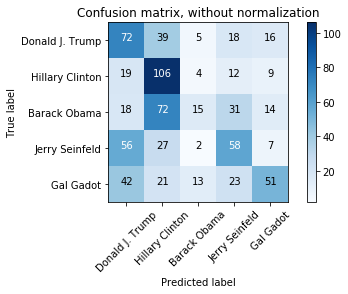

In [42]:
print(__doc__)

class_names = ['Donald J. Trump', 'Hillary Clinton', 'Barack Obama', 'Jerry Seinfeld' ,'Gal Gadot' ]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(actual_tweeters, nb_predict_tweeters)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## Logistic Regression Result

We will report the accuracy of the Logistic Regression algorithm, on every famous. by using the model we trained in part 2, and the tweets we generated in part 3.

In [43]:
trump_right = 0
hilary_right = 0
seinfeld_right = 0
obama_right = 0
gadot_right = 0

for i in range(0, 150):
    if regresion.predict([all_trump_tweets_BOW[i]]) == 'Donald J. Trump' :
        trump_right = trump_right + 1
    if regresion.predict([all_hilary_tweets_BOW[i]]) == 'Hillary Clinton' :
        hilary_right = hilary_right + 1
    if regresion.predict([all_obama_tweets_BOW[i]]) == 'Barack Obama' :
        obama_right = obama_right + 1
    if regresion.predict([all_seinfeld_tweets_BOW[i]]) == 'Jerry Seinfeld' :
        seinfeld_right = seinfeld_right + 1
    if regresion.predict([all_gadot_tweets_BOW[i]]) == 'Gal Gadot' :
        gadot_right = gadot_right + 1
    
print ("We Succeded in: " + str((trump_right/150)*100) + " precent in prediction which tweets are of Trump from the tweets we generated for him")
print ("We Succeded in: " + str((hilary_right/150)*100) + " precent in prediction which tweets are of Hilary from the tweets we generated for her")
print ("We Succeded in: " + str((obama_right/150)*100) + " precent in prediction which tweets are of obama from the tweets we generated for him")
print ("We Succeded in: " + str((seinfeld_right/150)*100) + " precent in prediction which tweets are of Seinfeld from the tweets we generated for him")
print ("We Succeded in: " + str((gadot_right/150)*100) + " precent in prediction which tweets are of Gal Gadot from the tweets we generated for her")
print()
print ("We Succeded in: " + str(((gadot_right+seinfeld_right+trump_right+hilary_right+obama_right) /750)*100) + " precent in prediction which tweets are of the right person ")

We Succeded in: 37.333333333333336 precent in prediction which tweets are of Trump from the tweets we generated for him
We Succeded in: 42.0 precent in prediction which tweets are of Hilary from the tweets we generated for her
We Succeded in: 46.666666666666664 precent in prediction which tweets are of obama from the tweets we generated for him
We Succeded in: 44.0 precent in prediction which tweets are of Seinfeld from the tweets we generated for him
We Succeded in: 41.333333333333336 precent in prediction which tweets are of Gal Gadot from the tweets we generated for her

We Succeded in: 42.266666666666666 precent in prediction which tweets are of the right person 


## We can see above that The Regression algorithm is best recognizing all the persons tweets in the same probability( more or less) . and with this tweets this algorithm give the best results from all the others.


We will save the predictions of Logistic Regression on each one of the 750 new tweets, in order to plot confussion matrix.

In [44]:
regresion_predict_tweeters = []

for i in range(0, 150):
    regresion_predict_tweeters.extend(regresion.predict([all_trump_tweets_BOW[i]]))

for i in range(0, 150):
    regresion_predict_tweeters.extend(regresion.predict([all_hilary_tweets_BOW[i]]))

for i in range(0, 150):
    regresion_predict_tweeters.extend(regresion.predict([all_obama_tweets_BOW[i]]))
    
for i in range(0, 150):
    regresion_predict_tweeters.extend(regresion.predict([all_seinfeld_tweets_BOW[i]]))
    
for i in range(0, 150):
    regresion_predict_tweeters.extend(regresion.predict([all_gadot_tweets_BOW[i]]))

This will plot confussion matrix for the logistic regression algorithm.

Confusion matrix, without normalization
[[70 17 32 12 19]
 [12 56 44 20 18]
 [22 18 62 32 16]
 [34  9 35 63  9]
 [12  5 50 17 66]]


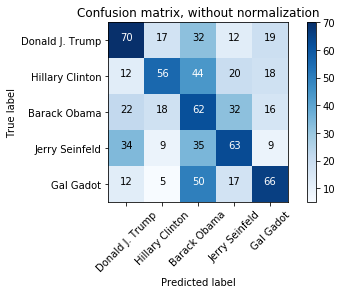

In [45]:
cnf_matrix = confusion_matrix(actual_tweeters, regresion_predict_tweeters)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## SVC Result

We will report the accuracy of the SVC algorithm, on every famous. by using the model we trained in part 2, and the tweets we generated in part 3.

In [46]:
trump_right = 0
hilary_right = 0
seinfeld_right = 0
obama_right = 0
gadot_right = 0

for i in range(0, 150):
    if svc.predict([all_trump_tweets_BOW[i]]) == 'Donald J. Trump' :
        trump_right = trump_right + 1
    if svc.predict([all_hilary_tweets_BOW[i]]) == 'Hillary Clinton' :
        hilary_right = hilary_right + 1
    if svc.predict([all_obama_tweets_BOW[i]]) == 'Barack Obama' :
        obama_right = obama_right + 1
    if svc.predict([all_seinfeld_tweets_BOW[i]]) == 'Jerry Seinfeld' :
        seinfeld_right = seinfeld_right + 1
    if svc.predict([all_gadot_tweets_BOW[i]]) == 'Gal Gadot' :
        gadot_right = gadot_right + 1
    
print ("We Succeded in: " + str((trump_right/150)*100) + " precent in prediction which tweets are of Trump from the tweets we generated for him")
print ("We Succeded in: " + str((hilary_right/150)*100) + " precent in prediction which tweets are of Hilary from the tweets we generated for her")
print ("We Succeded in: " + str((obama_right/150)*100) + " precent in prediction which tweets are of obama from the tweets we generated for him")
print ("We Succeded in: " + str((seinfeld_right/150)*100) + " precent in prediction which tweets are of Seinfeld from the tweets we generated for him")
print ("We Succeded in: " + str((gadot_right/150)*100) + " precent in prediction which tweets are of Gal Gadot from the tweets we generated for her")
print()
print ("We Succeded in: " + str(((gadot_right+seinfeld_right+trump_right+hilary_right+obama_right) /750)*100) + " precent in prediction which tweets are of the right person ")

We Succeded in: 23.333333333333332 precent in prediction which tweets are of Trump from the tweets we generated for him
We Succeded in: 37.333333333333336 precent in prediction which tweets are of Hilary from the tweets we generated for her
We Succeded in: 50.66666666666667 precent in prediction which tweets are of obama from the tweets we generated for him
We Succeded in: 49.333333333333336 precent in prediction which tweets are of Seinfeld from the tweets we generated for him
We Succeded in: 38.0 precent in prediction which tweets are of Gal Gadot from the tweets we generated for her

We Succeded in: 39.733333333333334 precent in prediction which tweets are of the right person 


## We can see above that The SVC algorithm is best recognizing Obama Tweets and Worst recognizing Trump Tweets. 

We will save the predictions of SVC on each one of the 750 new tweets, in order to plot confussion matrix.

In [47]:
svc_predict_tweeters = []

for i in range(0, 150):
    svc_predict_tweeters.extend(svc.predict([all_trump_tweets_BOW[i]]))

for i in range(0, 150):
    svc_predict_tweeters.extend(svc.predict([all_hilary_tweets_BOW[i]]))

for i in range(0, 150):
    svc_predict_tweeters.extend(svc.predict([all_obama_tweets_BOW[i]]))
    
for i in range(0, 150):
    svc_predict_tweeters.extend(svc.predict([all_seinfeld_tweets_BOW[i]]))
    
for i in range(0, 150):
    svc_predict_tweeters.extend(svc.predict([all_gadot_tweets_BOW[i]]))

This will plot confussion matrix for the SVC algorithm.

Confusion matrix, without normalization
[[76 12 42 10 10]
 [19 35 58 20 18]
 [30 16 57 32 15]
 [47  4 33 56 10]
 [14  6 41 15 74]]


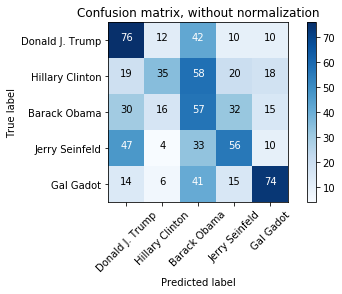

In [48]:
cnf_matrix = confusion_matrix(actual_tweeters, svc_predict_tweeters)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## KNN Result

We will report the accuracy of the KNN algorithm, on every famous. by using the model we trained in part 2, and the tweets we generated in part 3.

In [49]:
trump_right = 0
hilary_right = 0
seinfeld_right = 0
obama_right = 0
gadot_right = 0

for i in range(0, 150):
    if knn.predict([all_trump_tweets_BOW[i]]) == 'Donald J. Trump' :
        trump_right = trump_right + 1
    if knn.predict([all_hilary_tweets_BOW[i]]) == 'Hillary Clinton' :
        hilary_right = hilary_right + 1
    if knn.predict([all_obama_tweets_BOW[i]]) == 'Barack Obama' :
        obama_right = obama_right + 1
    if knn.predict([all_seinfeld_tweets_BOW[i]]) == 'Jerry Seinfeld' :
        seinfeld_right = seinfeld_right + 1
    if knn.predict([all_gadot_tweets_BOW[i]]) == 'Gal Gadot' :
        gadot_right = gadot_right + 1
    
print ("We Succeded in: " + str((trump_right/150)*100) + " precent in prediction which tweets are of Trump from the tweets we generated for him")
print ("We Succeded in: " + str((hilary_right/150)*100) + " precent in prediction which tweets are of Hilary from the tweets we generated for her")
print ("We Succeded in: " + str((obama_right/150)*100) + " precent in prediction which tweets are of obama from the tweets we generated for him")
print ("We Succeded in: " + str((seinfeld_right/150)*100) + " precent in prediction which tweets are of Seinfeld from the tweets we generated for him")
print ("We Succeded in: " + str((gadot_right/150)*100) + " precent in prediction which tweets are of Gal Gadot from the tweets we generated for her")
print()
print ("We Succeded in: " + str(((gadot_right+seinfeld_right+trump_right+hilary_right+obama_right) /750)*100) + " precent in prediction which tweets are of the right person ")

We Succeded in: 0.0 precent in prediction which tweets are of Trump from the tweets we generated for him
We Succeded in: 0.0 precent in prediction which tweets are of Hilary from the tweets we generated for her
We Succeded in: 0.0 precent in prediction which tweets are of obama from the tweets we generated for him
We Succeded in: 0.0 precent in prediction which tweets are of Seinfeld from the tweets we generated for him
We Succeded in: 100.0 precent in prediction which tweets are of Gal Gadot from the tweets we generated for her

We Succeded in: 20.0 precent in prediction which tweets are of the right person 


## We can see that this algorithm always chooses Gal Gadot as the person who tweeted. And is the worst from all the algorithms.

We will save the predictions of KNN on each one of the 750 new tweets, in order to plot confussion matrix.

In [50]:
knn_predict_tweeters = []

for i in range(0, 150):
    knn_predict_tweeters.extend(knn.predict([all_trump_tweets_BOW[i]]))

for i in range(0, 150):
    knn_predict_tweeters.extend(knn.predict([all_hilary_tweets_BOW[i]]))

for i in range(0, 150):
    knn_predict_tweeters.extend(knn.predict([all_obama_tweets_BOW[i]]))
    
for i in range(0, 150):
    knn_predict_tweeters.extend(knn.predict([all_seinfeld_tweets_BOW[i]]))
    
for i in range(0, 150):
    knn_predict_tweeters.extend(knn.predict([all_gadot_tweets_BOW[i]]))

This will plot confussion matrix for the KNN algorithm.

Confusion matrix, without normalization
[[  0   0 150   0   0]
 [  0   0 150   0   0]
 [  0   0 150   0   0]
 [  0   0 150   0   0]
 [  0   0 150   0   0]]


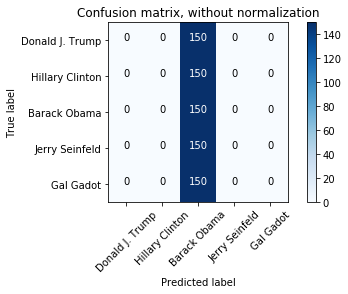

In [51]:
cnf_matrix = confusion_matrix(actual_tweeters, knn_predict_tweeters)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## Random Forest Result

We will report the accuracy of the Random Forest algorithm, on every famous. by using the model we trained in part 2, and the tweets we generated in part 3.

In [52]:
trump_right = 0
hilary_right = 0
seinfeld_right = 0
obama_right = 0
gadot_right = 0

for i in range(0, 150):
    if forest.predict([all_trump_tweets_BOW[i]]) == 'Donald J. Trump' :
        trump_right = trump_right + 1
    if forest.predict([all_hilary_tweets_BOW[i]]) == 'Hillary Clinton' :
        hilary_right = hilary_right + 1
    if forest.predict([all_obama_tweets_BOW[i]]) == 'Barack Obama' :
        obama_right = obama_right + 1
    if forest.predict([all_seinfeld_tweets_BOW[i]]) == 'Jerry Seinfeld' :
        seinfeld_right = seinfeld_right + 1
    if forest.predict([all_gadot_tweets_BOW[i]]) == 'Gal Gadot' :
        gadot_right = gadot_right + 1
    
print ("We Succeded in: " + str((trump_right/150)*100) + " precent in prediction which tweets are of Trump from the tweets we generated for him")
print ("We Succeded in: " + str((hilary_right/150)*100) + " precent in prediction which tweets are of Hilary from the tweets we generated for her")
print ("We Succeded in: " + str((obama_right/150)*100) + " precent in prediction which tweets are of obama from the tweets we generated for him")
print ("We Succeded in: " + str((seinfeld_right/150)*100) + " precent in prediction which tweets are of Seinfeld from the tweets we generated for him")
print ("We Succeded in: " + str((gadot_right/150)*100) + " precent in prediction which tweets are of Gal Gadot from the tweets we generated for her")
print()
print ("We Succeded in: " + str(((gadot_right+seinfeld_right+trump_right+hilary_right+obama_right) /750)*100) + " precent in prediction which tweets are of the right person ")

We Succeded in: 14.666666666666666 precent in prediction which tweets are of Trump from the tweets we generated for him
We Succeded in: 30.0 precent in prediction which tweets are of Hilary from the tweets we generated for her
We Succeded in: 22.0 precent in prediction which tweets are of obama from the tweets we generated for him
We Succeded in: 26.0 precent in prediction which tweets are of Seinfeld from the tweets we generated for him
We Succeded in: 75.33333333333333 precent in prediction which tweets are of Gal Gadot from the tweets we generated for her

We Succeded in: 33.6 precent in prediction which tweets are of the right person 


## We can see above that The Random Forest algorithm is best recognizing Gal Gadot Tweets and Worst recognizing Trump Tweets. 

We will save the predictions of Random Forest on each one of the 750 new tweets, in order to plot confussion matrix.

In [53]:
forest_predict_tweeters = []

for i in range(0, 150):
    forest_predict_tweeters.extend(forest.predict([all_trump_tweets_BOW[i]]))

for i in range(0, 150):
    forest_predict_tweeters.extend(forest.predict([all_hilary_tweets_BOW[i]]))

for i in range(0, 150):
    forest_predict_tweeters.extend(forest.predict([all_obama_tweets_BOW[i]]))
    
for i in range(0, 150):
    forest_predict_tweeters.extend(forest.predict([all_seinfeld_tweets_BOW[i]]))
    
for i in range(0, 150):
    forest_predict_tweeters.extend(forest.predict([all_gadot_tweets_BOW[i]]))

This will plot confussion matrix for the Random Forest algorithm.

Confusion matrix, without normalization
[[ 33   3  90  14  10]
 [  4  22 106  14   4]
 [ 14   0 113  21   2]
 [ 14   0  80  45  11]
 [  6   0  94  11  39]]


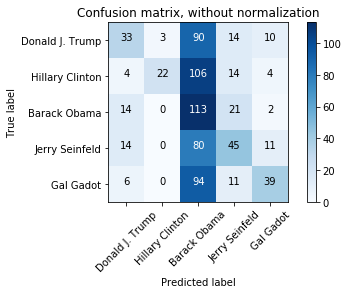

In [54]:
cnf_matrix = confusion_matrix(actual_tweeters, forest_predict_tweeters)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## conclusions


### most of our conclusions are detailed above. but we think we can improve the results in part 4, if we would build the sentence maybe with other algorithms than in Recurrent Neural Network, and maybe if instead of building the sentence his random words choosing we would do it by choosing the most impropriate word in each step.


### In our algorithm of choosing random word in each step when building the sentence we saw that the regression algorithm is the best classifier for the tweets we built and the knn is the worst.